In [1]:
""" External Imports """
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import sys
import yaml
import numpy as np
import re
import seaborn as sns
from datetime import datetime

sys.path.append("/Users/emilieyu/endotehelial-masboss")

ipylab module is not installed, menus and toolbar are disabled.


In [2]:
""" Global Setting Configuration """

PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
CONFIG_PATH = PROJECT_ROOT / "config" / "rho_sim_config.yaml"
SWEEP_CONFIG_PATH = PROJECT_ROOT / "config" / "parameter_sweep_config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

with open(SWEEP_CONFIG_PATH, "r") as f:
    sweep_config = yaml.safe_load(f)

# Result directory
RESULTS_DIR = PROJECT_ROOT / config['paths']['results_base']
FIG_DIR = PROJECT_ROOT / config['paths']['figures_base']

# Subdirectories to store parameter sweep / perturbation result
PARAM_DIR = RESULTS_DIR / config['paths']['subdirs']['param_sweep']
PERBS_DIR = RESULTS_DIR / config['paths']['subdirs']['perturbation_sim']
PERBS_FIG_DIR = FIG_DIR / config['paths']['subdirs']['perturbation_figs']
PARAM_FIG_DIR = FIG_DIR / config['paths']['subdirs']['param_sweep_figs']
PERBS_FIG_DIR.mkdir(parents=True, exist_ok=True)
PARAM_FIG_DIR.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")


In [3]:
perb_csv = PERBS_DIR / 'perturbation_timeseries.csv'
perb_raw = pd.read_csv(perb_csv)

In [4]:
param_csv = PARAM_DIR / 'param_sweep_full.csv'
param_df = pd.read_csv(param_csv)


In [5]:
param_df

,DSP,JCAD,RhoA,RhoC,TJP1,p1_name,p1_value,p2_name,p2_value,perturbation,exp_name,type,delta,phenotype
0,0.500201,0.506601,0.525727,0.561126,0.496201,$RhoA_amp,5.0,NaN,NaN,WT,WT_Sweep,1D,0.035399,Normal
1,0.507001,0.482998,0.541763,0.561503,0.508000,$RhoA_amp,7.5,NaN,NaN,WT,WT_Sweep,1D,0.019740,Normal
2,0.499800,0.513600,0.557718,0.557474,0.493601,$RhoA_amp,10.0,NaN,NaN,WT,WT_Sweep,1D,-0.000244,Normal
3,0.496998,0.492999,0.560247,0.543822,0.505800,$RhoA_amp,12.5,NaN,NaN,WT,WT_Sweep,1D,-0.016425,Normal
4,0.498801,0.501802,0.556315,0.553360,0.494200,$RhoA_amp,15.0,NaN,NaN,WT,WT_Sweep,1D,-0.002955,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,NaN,NaN,0.360222,0.613192,0.508001,$RhoC_amp,35.0,$RhoC_mod,2.0,DSP_JCAD,Amplification_Gain_RhoC,2D,0.252970,Hyper
1062,NaN,NaN,0.353979,0.626955,0.498800,$RhoC_amp,35.0,$RhoC_mod,2.5,DSP_JCAD,Amplification_Gain_RhoC,2D,0.272976,Hyper
1063,NaN,NaN,0.345272,0.651514,0.507599,$RhoC_amp,35.0,$RhoC_mod,3.0,DSP_JCAD,Amplification_Gain_RhoC,2D,0.306242,Hyper
1064,NaN,NaN,0.340615,0.652081,0.493200,$RhoC_amp,35.0,$RhoC_mod,3.5,DSP_JCAD,Amplification_Gain_RhoC,2D,0.311466,Hyper


## 1D Experiements Processing

In [6]:
def plot_1d_sensitivity(df, outdir=None):
    df_1d = df[df['type'] == "1D"].dropna(axis=1).copy()
    params = df_1d['p1_name'].unique()

    for p in params:
        plt.figure(figsize=(6, 4))
        data = df_1d[df_1d['p1_name'] == p]
        
        # Create the line plot
        sns.lineplot(
            data=data, x='p1_value', y='delta', 
            hue='perturbation', style='perturbation',
            markers=True, dashes=False
        )
        
        # Add Phenotype Shading (The "Zones")
        plt.axhspan(0.25, 1.0, color='blue', alpha=0.1, label='Hyper (RhoC)')
        plt.axhspan(-0.25, 0.25, color='gray', alpha=0.1, label='Normal (Balanced)')
        plt.axhspan(-1.0, -0.25, color='red', alpha=0.1, label='Failed (RhoA)')
        
        # Formatting
        plt.title(f"Sensitivity Analysis: {p}")
        plt.xlabel(f"Parameter Value: {p}")
        plt.ylabel("Balance ($\Delta = RhoC - RhoA$)")
        plt.ylim(-0.8, 0.8)
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
        plt.tight_layout()

        if outdir is not None: 
            outpath = outdir / f"sensitivity_{p.replace('$', '')}.png"
            plt.savefig(outpath, dpi=300)

        plt.show()
        plt.close()



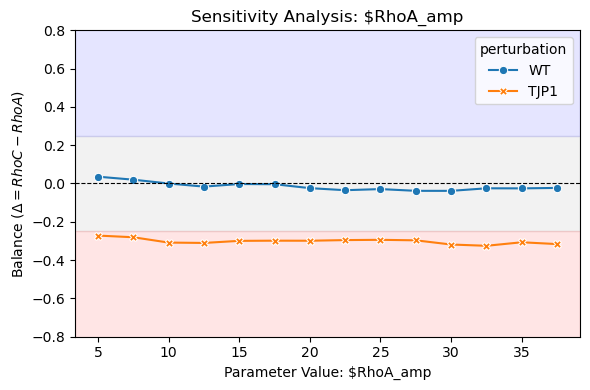

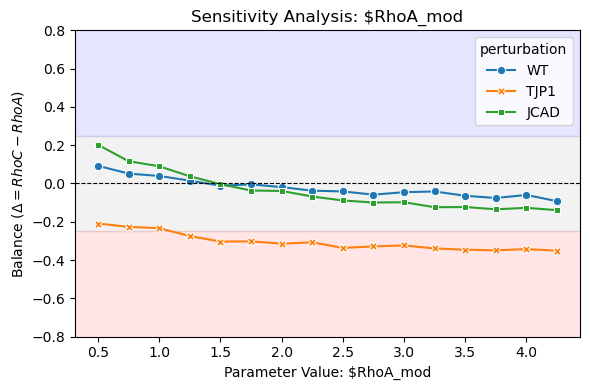

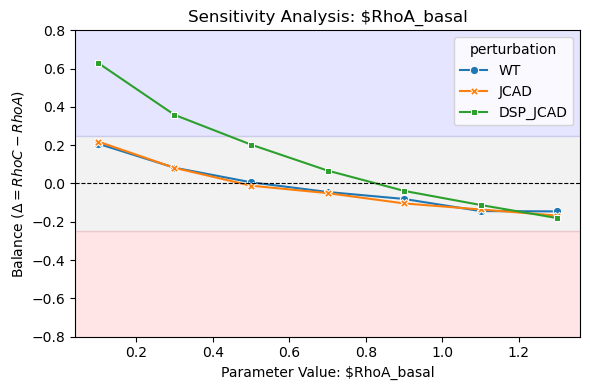

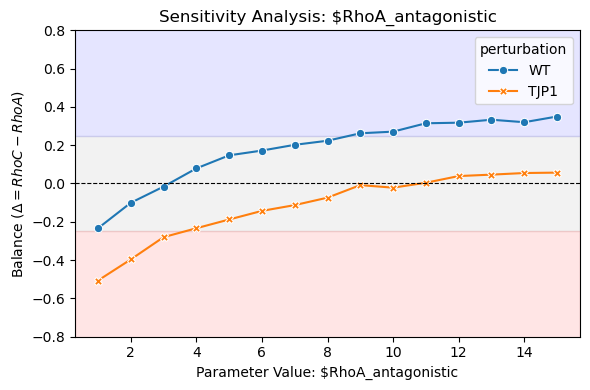

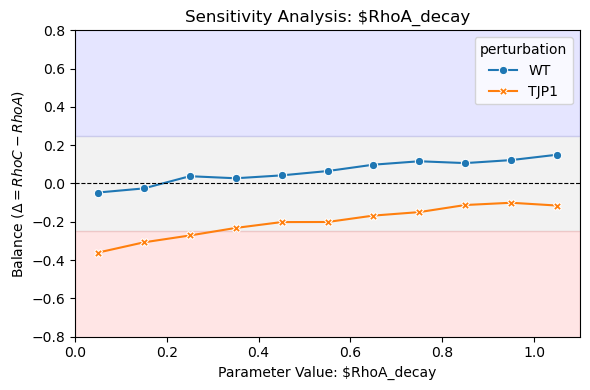

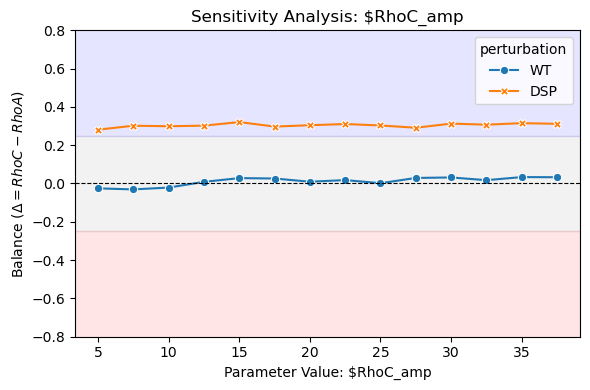

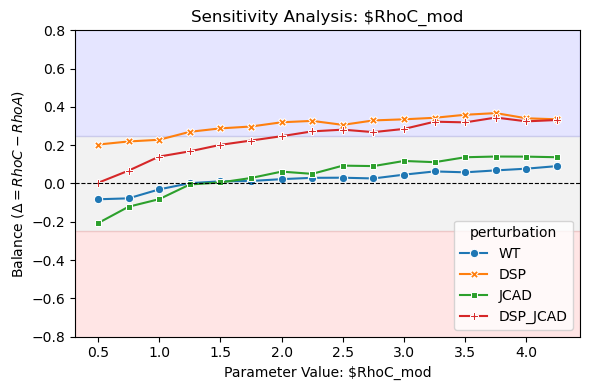

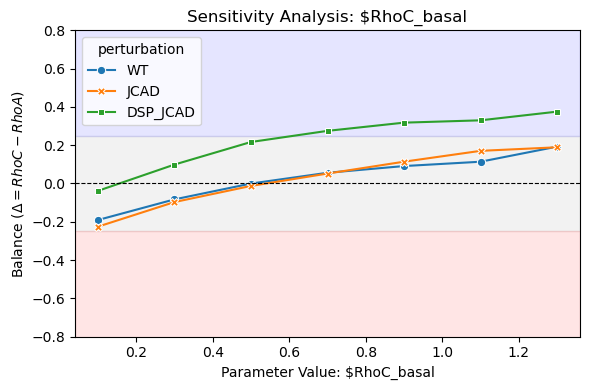

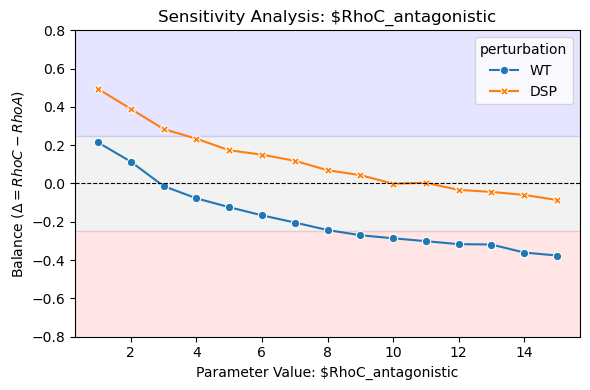

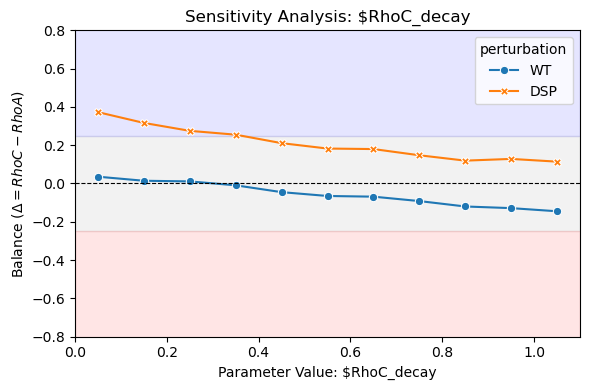

In [7]:
plot_1d_sensitivity(param_df, PARAM_FIG_DIR)

## 2D Param Sweep Processing

In [8]:
df_2d = param_df[param_df['type'] == "2D"].dropna(axis=1).copy()
df_2d

,RhoA,RhoC,p1_name,p1_value,p2_name,p2_value,perturbation,exp_name,type,delta,phenotype
314,0.633653,0.641031,$RhoA_antagonistic,1.0,$RhoC_antagonistic,1.0,WT,Competition_Landscape,2D,0.007378,Normal
315,0.692708,0.480291,$RhoA_antagonistic,1.0,$RhoC_antagonistic,3.0,WT,Competition_Landscape,2D,-0.212417,Normal
316,0.724304,0.398877,$RhoA_antagonistic,1.0,$RhoC_antagonistic,5.0,WT,Competition_Landscape,2D,-0.325427,Failed
317,0.737630,0.348905,$RhoA_antagonistic,1.0,$RhoC_antagonistic,7.0,WT,Competition_Landscape,2D,-0.388725,Failed
318,0.749170,0.322184,$RhoA_antagonistic,1.0,$RhoC_antagonistic,9.0,WT,Competition_Landscape,2D,-0.426986,Failed
...,...,...,...,...,...,...,...,...,...,...,...
1061,0.360222,0.613192,$RhoC_amp,35.0,$RhoC_mod,2.0,DSP_JCAD,Amplification_Gain_RhoC,2D,0.252970,Hyper
1062,0.353979,0.626955,$RhoC_amp,35.0,$RhoC_mod,2.5,DSP_JCAD,Amplification_Gain_RhoC,2D,0.272976,Hyper
1063,0.345272,0.651514,$RhoC_amp,35.0,$RhoC_mod,3.0,DSP_JCAD,Amplification_Gain_RhoC,2D,0.306242,Hyper
1064,0.340615,0.652081,$RhoC_amp,35.0,$RhoC_mod,3.5,DSP_JCAD,Amplification_Gain_RhoC,2D,0.311466,Hyper


In [9]:
def plot_experiment_heatmaps(exp_df, outdir=None):
    # Extract Metadata
    exp_name = exp_df['exp_name'].iloc[0]


    perturbations = exp_df["perturbation"].unique()
    n_perbs = len(perturbations)

    # Create figure and axes for plotting
    fig, axes = plt.subplots(nrows=1, ncols=n_perbs, figsize=(6*n_perbs, 6), constrained_layout=True)
    fig.suptitle(exp_name, fontsize=16)

    # Ensure axes is iterable if only one subplot
    if n_perbs == 1:
        axes = [axes]

    heatmap = None  # will store first heatmap

    # Global color limits for consistent scaling
    vmin = exp_df["delta"].min()
    vmax = exp_df["delta"].max()

    for ax, perb in zip(axes, perturbations):
        perb_df = exp_df[exp_df["perturbation"] == perb]
        p1_name = perb_df['p1_name'].iloc[0]
        p2_name = perb_df['p2_name'].iloc[0]

        pivot_df = perb_df.pivot(index='p1_value', columns='p2_value', values='delta')

        hm = sns.heatmap(
            pivot_df, annot=True, cmap="RdBu",
            center=0, vmin=vmin, vmax=vmax, cbar=False, ax=ax
        )

        ax.set_title(perb)
        ax.set_xlabel(p2_name)
        ax.set_ylabel(p1_name)
        if heatmap is None:
            heatmap = hm

    cbar = fig.colorbar(heatmap.collections[0], ax=axes, shrink=0.8, fraction=0.05, pad=0.04)
    cbar.set_label("Delta (RhoC - RhoA)")

    if outdir is not None: 
        outpath = outdir / f"{exp_name}_heatmaps.png"
        plt.savefig(outpath, dpi=300)

    plt.show()


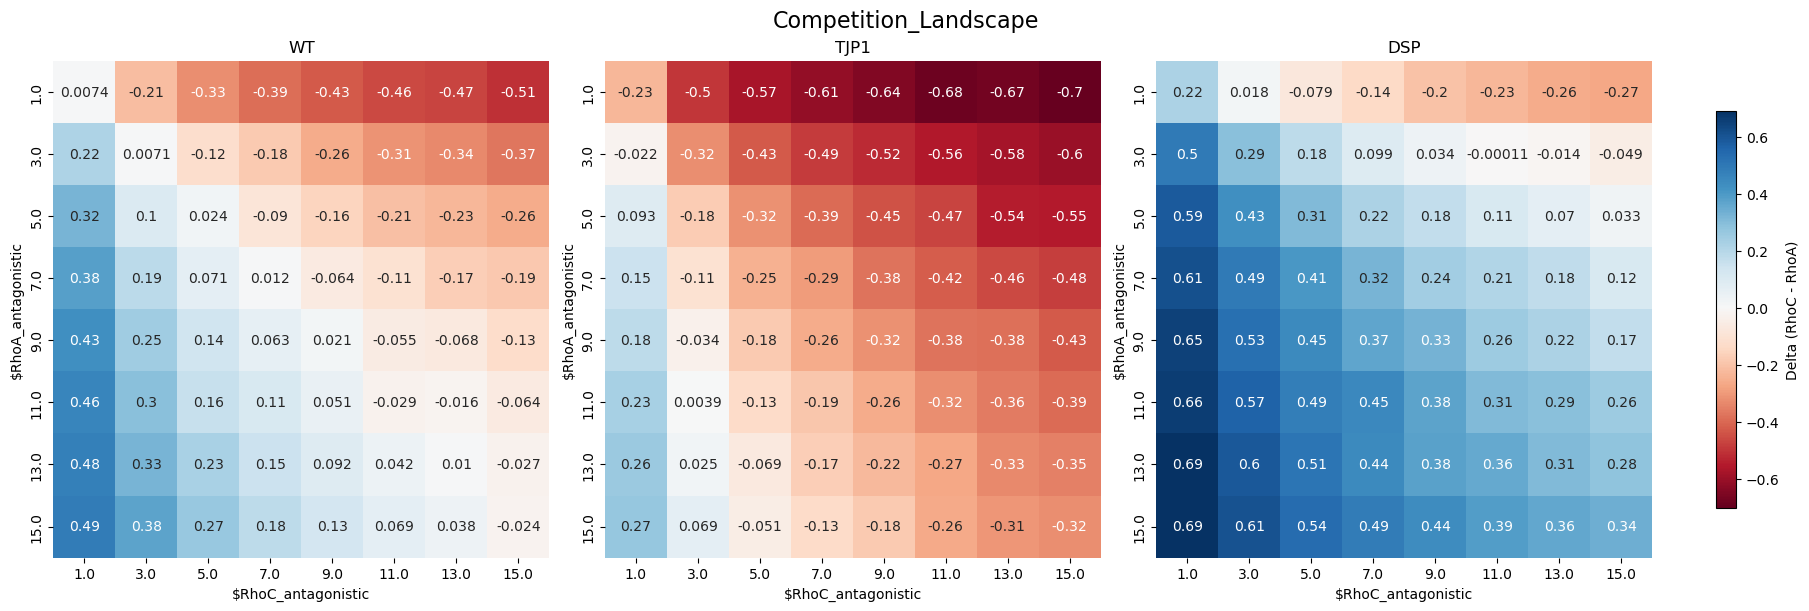

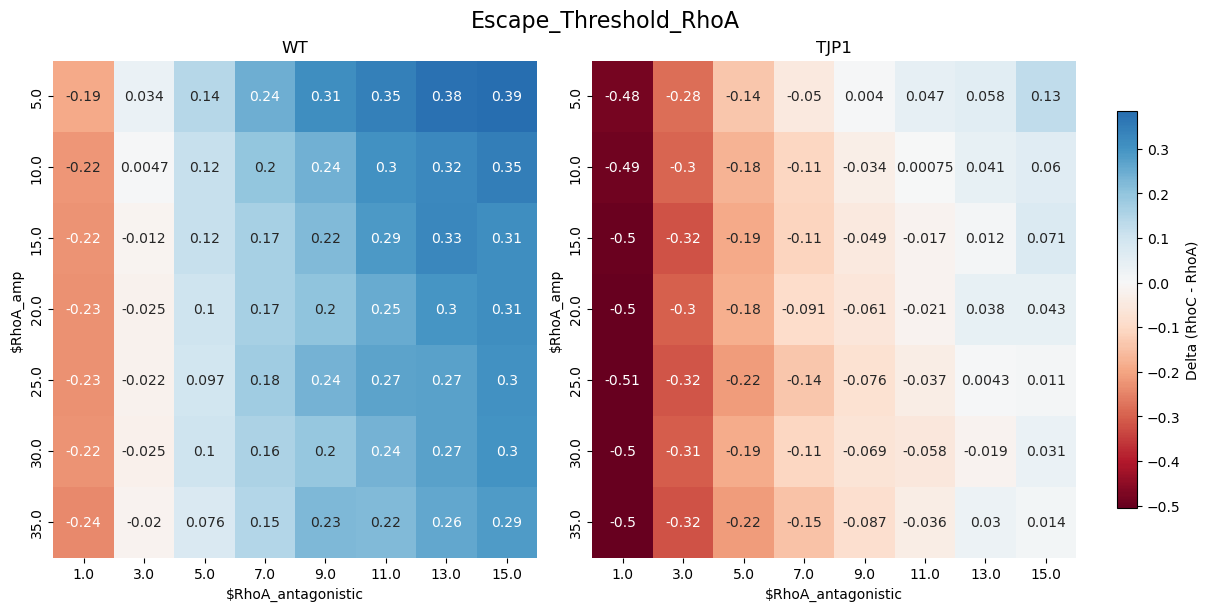

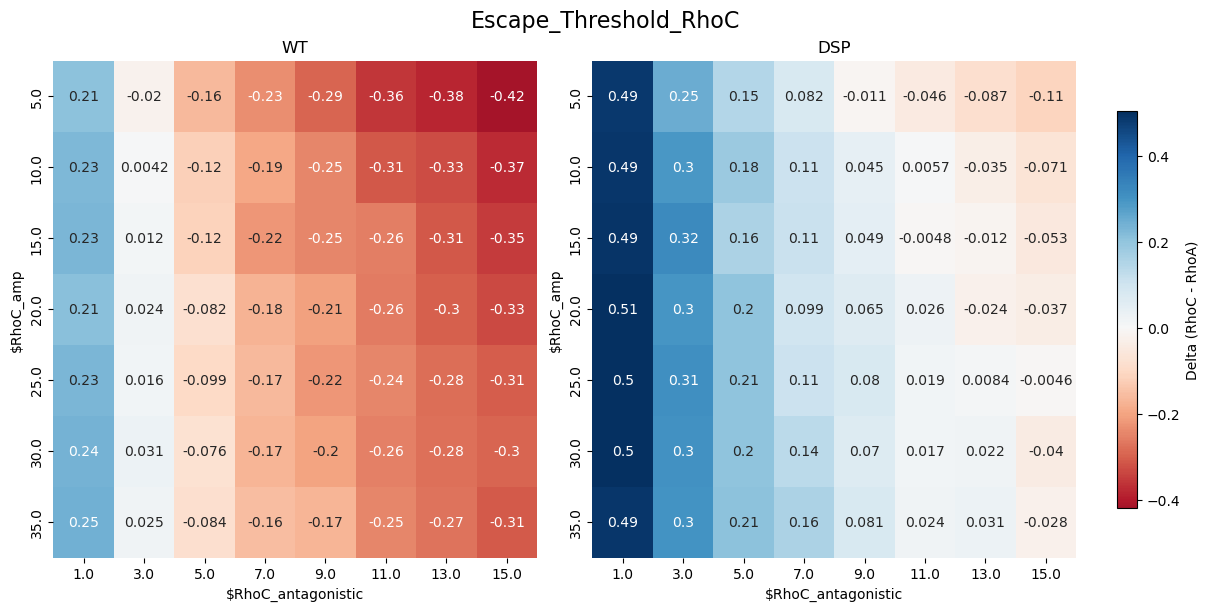

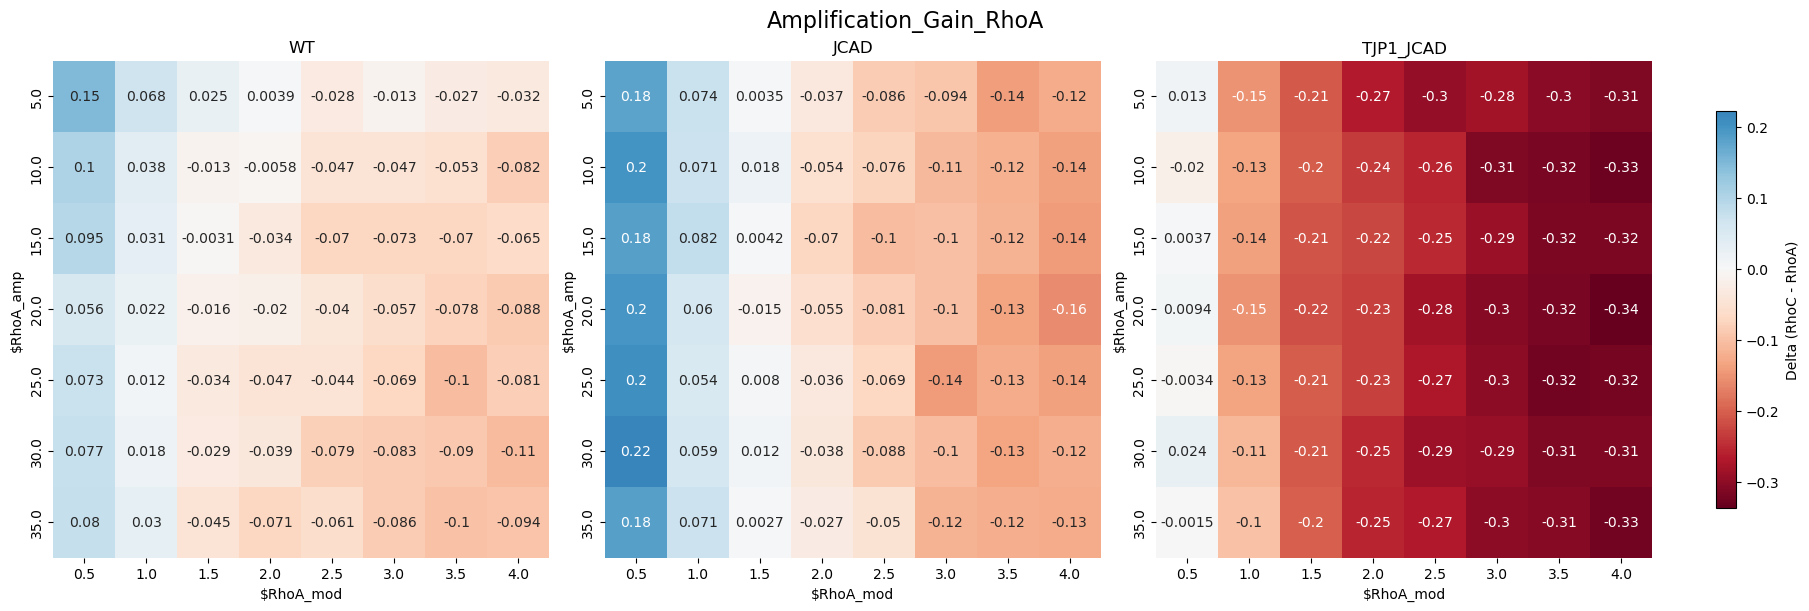

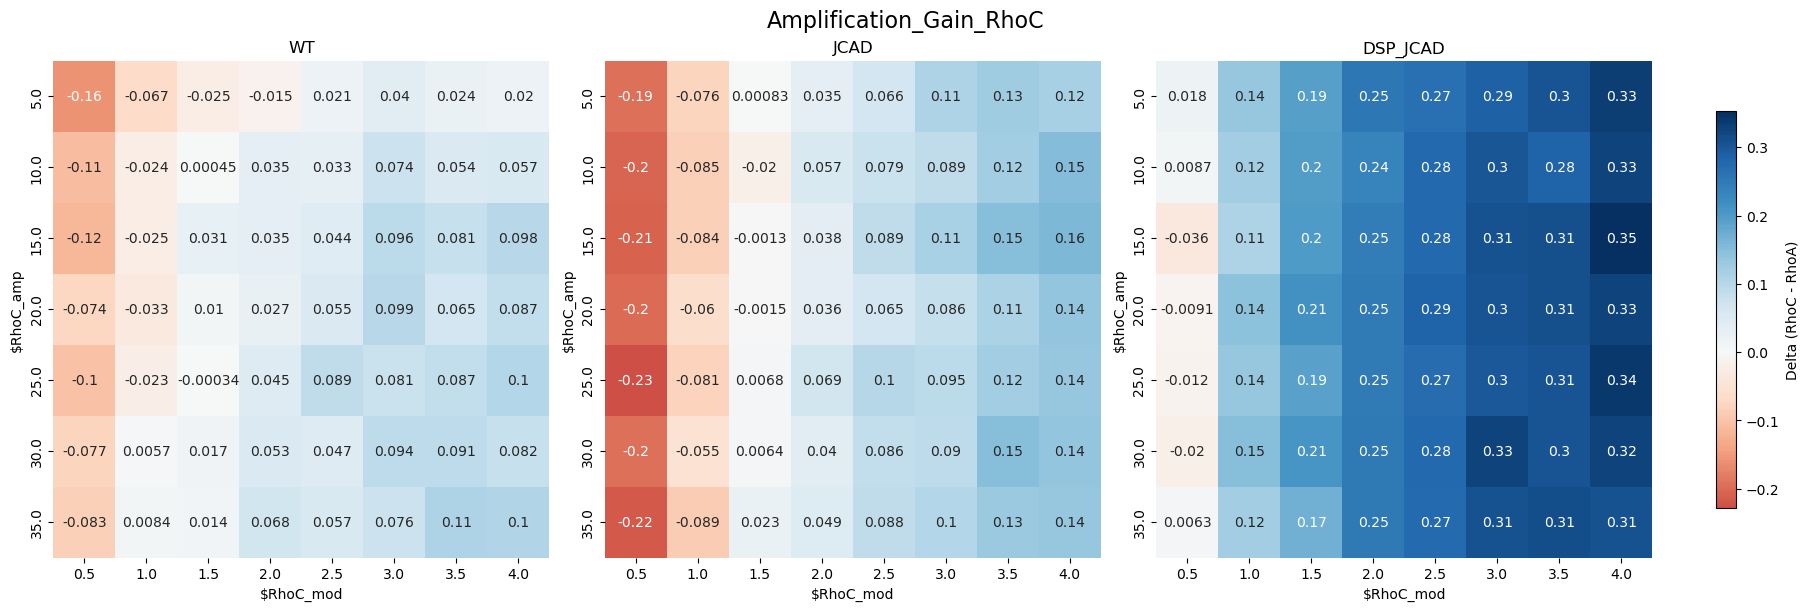

In [10]:

for exp in df_2d['exp_name'].unique():
    exp_df = df_2d[df_2d['exp_name'] == exp]
    plot_experiment_heatmaps(exp_df, PARAM_FIG_DIR)

## Perturbation Processing

In [19]:
def plot_activation_single(perb, df, ax, set_ylim=True):
    """
    Plot RhoA/RhoC activation levels / probabilities for a single perturbation. 
    """
    ax.plot(df['t'], df['RhoA'], label=f"{perb} RhoA")
    ax.plot(df['t'], df['RhoC'], label=f"{perb} RhoC")

    if set_ylim:
        ax.set_ylim(0, 1)

    ax.set_xlabel('Time')
    ax.set_ylabel('Activation Level (Probability)')

    plt.tight_layout()


def plot_activation_prob(name, perb_list, data_dict, outdir=None, set_ylim=True, save=True):
    fig, ax = plt.subplots(figsize=(6,4))

    for perb in perb_list:
        plot_activation_single(perb, data_dict[perb], ax=ax, set_ylim=set_ylim)

    ax.set_title(f"{name}: RhoA/RhoC Activation Over Time")
    ax.legend()
    plt.tight_layout()

    if save and outdir is not None:
        file_name = name.replace(" ", "_")
        fig.savefig(outdir / f"{file_name}_rho_acivation_time.png", dpi=300)

    plt.show()
    plt.close(fig)

def plot_delta_single(perb, df, ax):
    """
    Plot Δ(t) for a single perturbation onto an existing axis.
    """

    ax.plot(df['t'], df["delta"], label=perb)

    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")


def plot_deltas(name, perb_list, data_dict, outdir=None, save=True):
    """
    Plot one or multiple perturbations' Δ(t) on the same axes.
    """
    fig, ax = plt.subplots(figsize=(6,4))

    # Plot each perturbation
    for perb in perb_list:
        plot_delta_single(perb, data_dict[perb], ax)

    # Add reference lines ONCE
    ax.axhline(0.25, linestyle="--", color='mistyrose')
    ax.axhline(-0.25, linestyle="--", color='mistyrose')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_title(f"{name}: Rho Balance Over Time (Δ)")
    ax.legend(title='Perturbation')
    plt.tight_layout()

    if save and outdir is not None:
        file_name = name.replace(" ", "_")
        outpath = outdir / f"{file_name}_delta_time.png"
        fig.savefig(outpath, dpi=300)

    plt.show()

    plt.close()


In [20]:
perb_dfs = {}
for perb, df in perb_raw.groupby('perturbation'):
    perb_dfs[perb] = df

    #plot_activation_prob(perb, [perb], perb_dfs, PERBS_FIG_DIR)
    #plot_deltas(perb, df)


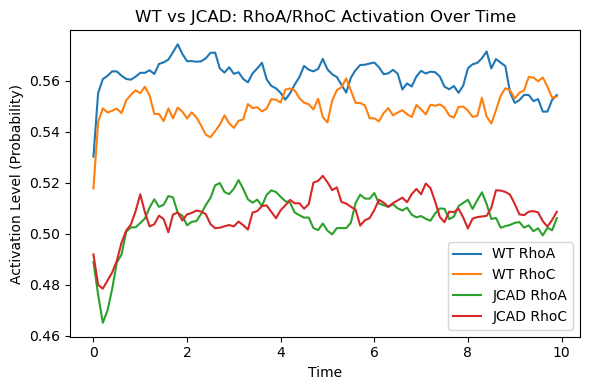

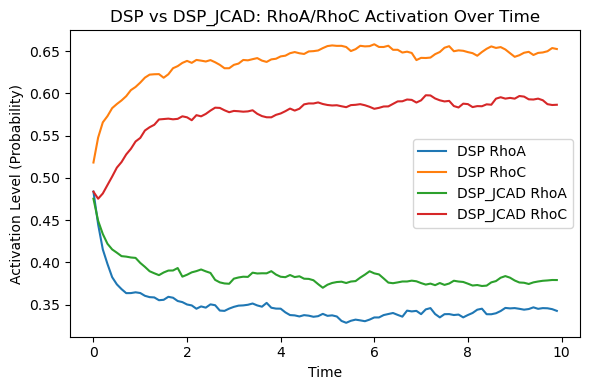

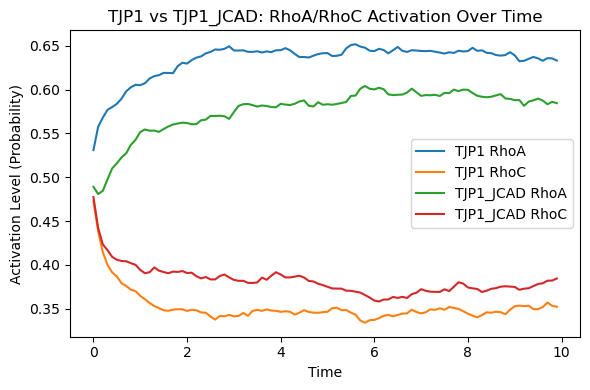

In [21]:
plot_activation_prob('WT vs JCAD', ['WT', 'JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)
plot_activation_prob('DSP vs DSP_JCAD', ['DSP', 'DSP_JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)
plot_activation_prob('TJP1 vs TJP1_JCAD', ['TJP1', 'TJP1_JCAD'], perb_dfs, PERBS_FIG_DIR, set_ylim=False)

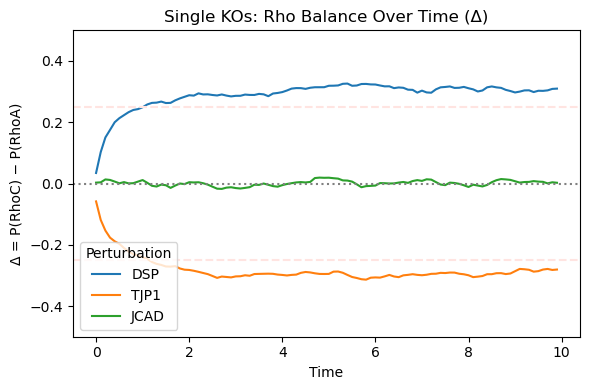

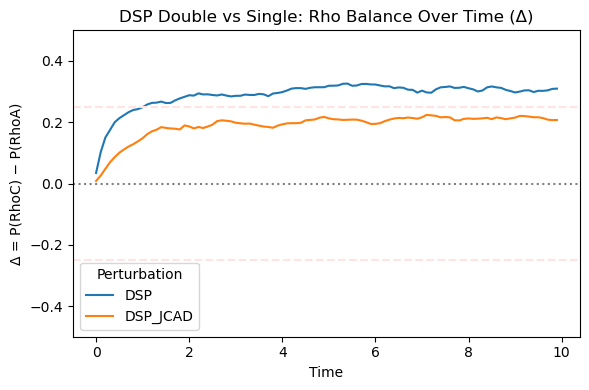

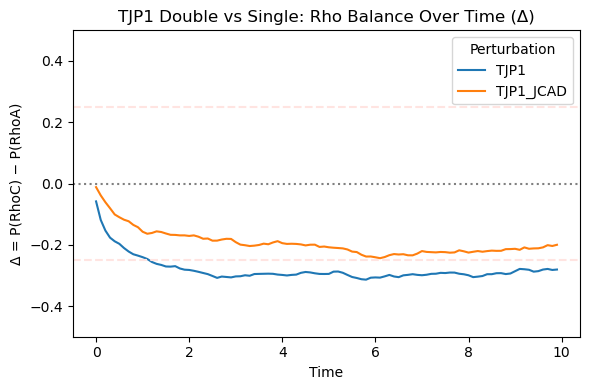

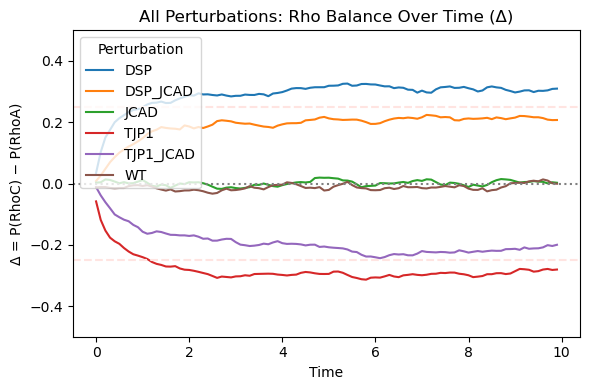

In [22]:
plot_deltas('Single KOs', ['DSP', 'TJP1', 'JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('DSP Double vs Single', ['DSP', 'DSP_JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('TJP1 Double vs Single', ['TJP1', 'TJP1_JCAD'], perb_dfs, PERBS_FIG_DIR)
plot_deltas('All Perturbations', perb_dfs.keys(), perb_dfs, PERBS_FIG_DIR)

## Perturbation Steady State Plots

In [23]:
def plot_ss_bar(df, outdir=None, save=True):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(df['perturbation'], df['delta'])

    ax.axhline(0.25, linestyle="--", color='red')
    ax.axhline(-0.25, linestyle="--", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylabel("Steady-State Δ")
    ax.set_ylabel("Perturbation")
    ax.set_title("Steady-State Rho Balances")

    plt.tight_layout()
    plt.show()

    if save and outdir is not None:
        outpath = outdir / "ss_balance_bar.png"
        fig.savefig(outpath, dpi=300)

    plt.show()

    plt.close(fig)


def save_df_as_png(df, filename, outdir = None, save=True, dpi=300):
    """
    Save a pandas DataFrame as a PNG image.
    """

    # Scale figure size based on dataframe shape
    nrows, ncols = df.shape

    fig, ax = plt.subplots(figsize=(ncols * 1.2, nrows * 0.4))
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        cellLoc='left',
        colLabels=df.columns.str.capitalize(),
        colColours=['lightblue']*ncols,
        loc='center'
    )


    table.auto_set_column_width(col=list(range(ncols)))
    table.scale(1, 1.2)

    # Bold header row
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')

    plt.tight_layout()
    if save and outdir is not None:
        outpath = outdir / "ss_table.png"
        fig.savefig(outpath, dpi=300)

    plt.show()
    plt.close(fig)

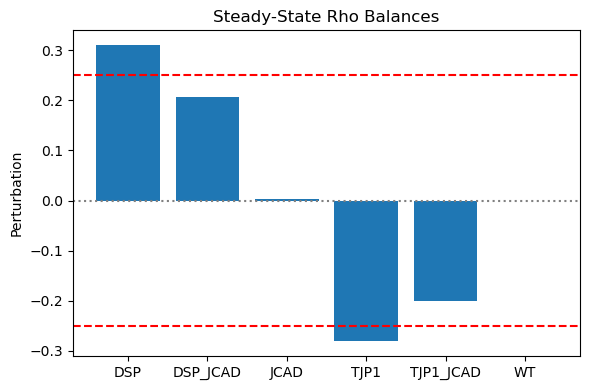

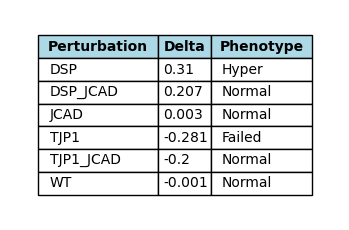

In [24]:
ss_df = perb_raw.loc[perb_raw.groupby('perturbation')['t'].idxmax()].reset_index(drop=True)
ss_df
ss_processed = ss_df[['perturbation', 'delta', 'phenotype']].round(3)
plot_ss_bar(ss_processed, PERBS_FIG_DIR)
save_df_as_png(ss_processed, "ss_table", PERBS_FIG_DIR)